In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

## 1. Visualize the data and Preprocess

In [2]:
# load data
ninapro_root = "./Ninapro/DB8"
print(os.path.abspath(ninapro_root))

ex3_file = os.path.join(ninapro_root, "S1_E1_A1.mat")

data = loadmat(ex3_file)

# Inspect available keys, except the ones starting with "__"
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

/data/NSSP_project2_groupK/Ninapro/DB8
Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


In [3]:
# First let's check the size of glove
glove_data = data["glove"]
print("Glove data dimension: {}".format(glove_data.shape))
print("Glove data type: {}".format(type(glove_data)))
#Yes indeed on the scheme of the instructions we can see that we have 18 types of glove variable

# First let's check the size of emg
emg_data = data["emg"] #keep all 16 channels !!
print("emg data dimension: {}".format(emg_data.shape))
print("emg data type: {}".format(type(emg_data)))
#which is right, looking at the documentation we are meant to have 18 in EMG

#We need to use the joint angles 3,6,8,11,14
target_joints = [2, 5, 7, 10, 13]  # Keep only the target joints of the finger
glove_fingers = glove_data[:, target_joints]
print("Glove of joint 3,6,8,11,14 data dimension: {}".format(glove_fingers.shape))
print("Glove of joint 3,6,8,11,14 data type: {}".format(type(glove_fingers)))

Glove data dimension: (2292526, 18)
Glove data type: <class 'numpy.ndarray'>
emg data dimension: (2292526, 16)
emg data type: <class 'numpy.ndarray'>
Glove of joint 3,6,8,11,14 data dimension: (2292526, 5)
Glove of joint 3,6,8,11,14 data type: <class 'numpy.ndarray'>


Text(0, 0.5, 'Amplitude')

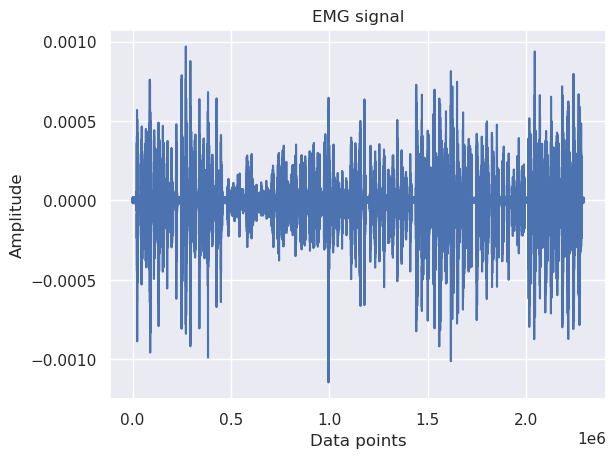

In [4]:
#plot 1st channel 
plt.close("all")
fig, ax = plt.subplots()
ax.plot(emg_data[:, 5])   
ax.set_title("EMG signal")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

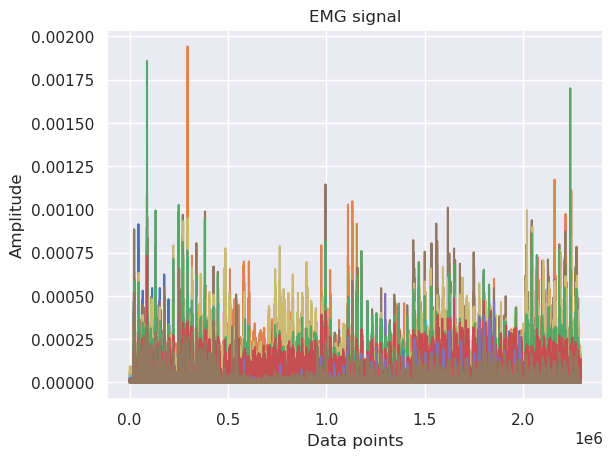

In [5]:
#We need to preprocess EMG and print the absolute value
emg_data_rect = np.abs(emg_data)

plt.close("all")
fig, ax = plt.subplots()
ax.plot(np.abs(emg_data_rect))   
ax.set_title("EMG signal")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

Checking if the powerline noise is influencing the signal or not enough to do powerline filtering. it's electrical contamination at 50hz (EU) or 60hz (US). As we can see this filtering looks to have already been done.

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

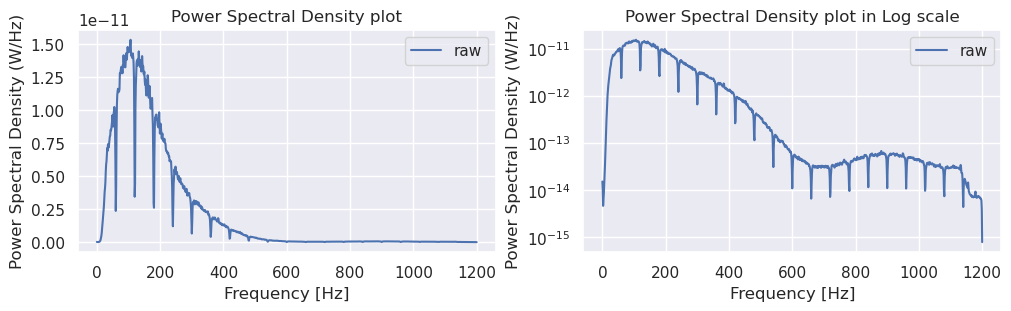

In [6]:
# Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg_data[:, 8], fs=2400, nperseg=2048) #just checking for channel #8 here !

# IMPORTANT to take emg_data and not emg_data_rect

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3)) 
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

the "holes" that we are seeing might be the preprocess already done on the dataset to delete the powerline noise and its harmonics. As we can see the first hole on the left table is at 50hz !

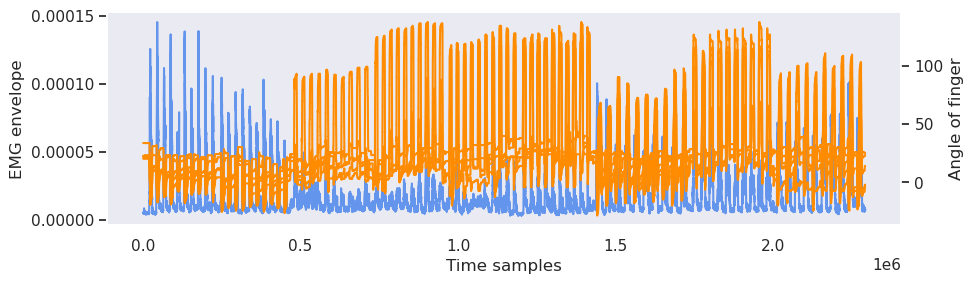

In [7]:
mov_mean_size = 400 # moving average filter of a length of 50 samples 
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size 
EMG_envelopes = convolve1d(np.abs(emg_data), weights=mov_mean_weights, axis=0) # we take the absolute value of emg again !
#convolve1d smooths absolute EMG 

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(EMG_envelopes[:, 0],color = 'cornflowerblue', label="EMG envelope")
ax.set_ylabel("EMG envelope")
ax.set_xlabel("Time samples")
ax.grid(False)

finger_angle_ax = ax.twinx()
finger_angle_ax.plot(glove_fingers, color="darkorange", label="Angle of finger") #important to take data of glove_fingers 
finger_angle_ax.set_ylabel("Angle of finger")# and not take glove_data // or we could take glove_data[:, target_joints]
finger_angle_ax.grid(False)

# Get handles and labels for legend
emg_handles, emg_labels = ax.get_legend_handles_labels()
finger_angle_handles, finger_angle_labels = finger_angle_ax.get_legend_handles_labels()

# Combine handles and labels
combined_handles = emg_handles + finger_angle_handles
combined_labels = emg_labels + finger_angle_labels

# Create a single legend
#ax.legend(combined_handles, combined_labels, loc='upper left')
plt.tight_layout()

EMG_enveloppes has same shape as emg_data, but each channel is smoothed over 50 samples

In [8]:
from sklearn.model_selection import train_test_split

# your full signals (after preprocessing but BEFORE windowing)
X = EMG_envelopes          # shape (N, 16) ==> of course calculated with np.abs(emg_data)
Y = glove_fingers          # shape (N, 5) ==> of course not glove_data, but specifically of the fingers
 
#first split: Train vs (Val+Test) ----
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y,test_size=0.40,shuffle=False)

#second split: Validation vs Test ----
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp,test_size=0.50,shuffle=False)

print("train:", X_train.shape, Y_train.shape)
print("Val:  ", X_val.shape,   Y_val.shape)
print("Test: ", X_test.shape,  Y_test.shape)

train: (1375515, 16) (1375515, 5)
Val:   (458505, 16) (458505, 5)
Test:  (458506, 16) (458506, 5)


# 2. Perform sliding windows
To process the dataset efficiently, we divide it into overlapping sliding windows. 
This approach allows us to extract smaller segments of the EMG data, each corresponding to a specific time interval. 
The sliding window technique ensures that we capture temporal patterns in the signal by dividing it into time segments,
while maintaining continuity through overlapping segments.

In [9]:
fs = 2400  # [Hz], it should always be 2400hz
emg_window_length_sec = 100e-3  # [s]
incremental_window_length_sec = 25e-3  # [s]  IT should be 10ms but kills the kernel so for now let's do 50 ms

In [10]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

In [11]:
from sklearn.model_selection import train_test_split
# extract over lapping time windows on the whole dataset before splitting the dataset into train, validation and test

emg_train_windows,labels_train_windows = extract_time_windows_regression(X_train,Y_train,fs,emg_window_length_sec,incremental_window_length_sec)
emg_test_windows,labels_test_windows = extract_time_windows_regression(X_test,Y_test,fs,emg_window_length_sec,incremental_window_length_sec)
emg_val_windows,labels_val_windows = extract_time_windows_regression(X_val,Y_val,fs,emg_window_length_sec,incremental_window_length_sec)

emg_window_length_sec,incremental_window_length_sec

print(f"EMG train data shape: {emg_train_windows.shape}, Train label shape: {labels_train_windows.shape}")
print(f"EMG test data shape: {emg_test_windows.shape}, Test label shape: {labels_test_windows.shape}")
print(f"EMG validation data shape: {emg_val_windows.shape}, Validation label shape: {labels_val_windows.shape}")

#shapes seems right, 16 for the 16 EMG channels
# 18 for the 18 joint

EMG train data shape: (22922, 240, 16), Train label shape: (22922, 240, 5)
EMG test data shape: (7638, 240, 16), Test label shape: (7638, 240, 5)
EMG validation data shape: (7638, 240, 16), Validation label shape: (7638, 240, 5)


Expected results : 
windows length = 50 ms = 0.05 s. Window sample = fs * 0.05 = 2400 * 0.05 = 120 samples

EMG train ==> each 120 timepoints long, 16 emg channels
labels train ==>120 timepoints, and 5 joint angles (the 5 target joints from the 5 fingers)

EMG test ==> 120 timepoints long, 16 emg channels
labels test ==> 120 timepoints, and 5 joint angles 

our test set is smaller than train set !

# 3. Extract a set of features, normalize them and visualize the correlation between them

In [12]:
def extract_features(EMG_windows: np.ndarray, labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean, the standard deviation and the maximum amplitude of each window and the mean of the labels window
    """
    # along axis 1, which is the time axis
    EMG_mean = np.mean(EMG_windows, axis=1)
    EMG_std = np.std(EMG_windows, axis=1)
    EMG_max_amplitude = np.max(EMG_windows, axis=1)
    
    labels_mean = np.mean(labels_windows,axis=1)
    
    # Concatenate the mean and std of each window
    emg_extracted_features = np.concatenate((EMG_mean, EMG_std, EMG_max_amplitude), axis=1)
    return emg_extracted_features, labels_mean

In [13]:
emg_train_extracted_features, labels_train_mean = extract_features(emg_train_windows,labels_train_windows)
emg_test_extracted_features, labels_test_mean = extract_features(emg_test_windows,labels_test_windows)
emg_val_extracted_features, labels_val_mean = extract_features(emg_val_windows,labels_val_windows)

print("EMG train extracted features shape: {}, Finger labels feature shape:{}".format(emg_train_extracted_features.shape, labels_train_mean.shape))
print("EMG test extracted features shape: {}, Finger labels feature shape:{}".format(emg_test_extracted_features.shape, labels_test_mean.shape))
print("EMG val extracted features shape: {}, Finger labels feature shape:{}".format(emg_val_extracted_features.shape, labels_val_mean.shape))

EMG train extracted features shape: (22922, 48), Finger labels feature shape:(22922, 5)
EMG test extracted features shape: (7638, 48), Finger labels feature shape:(7638, 5)
EMG val extracted features shape: (7638, 48), Finger labels feature shape:(7638, 5)


# Normalize

In [40]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#scaler = StandardScaler()
#emg_train_norm = scaler.fit_transform(emg_train_extracted_features) #now each feature has mean 0,std 1 across all windows
#emg_test_norm = scaler.transform(emg_test_extracted_features)
#emg_val_norm = scaler.transform(emg_val_extracted_features)

#let's try and normalize angles (labels), for better prediction

scaler= StandardScaler()

x_train_s = scaler.fit_transform(emg_train_extracted_features)
y_train_s = scaler.fit_transform(labels_train_mean)
x_val_s   = scaler.transform(emg_val_extracted_features)
y_val_s   = scaler.transform(labels_val_mean)
x_test_s  = scaler.transform(emg_test_extracted_features)
y_test_s  = scaler.transform(labels_test_mean)

ValueError: X has 48 features, but StandardScaler is expecting 5 features as input.

In [41]:
import numpy as np
def print_range(name, arr):
    print(f"{name}: min={np.nanmin(arr):.2f}, max={np.nanmax(arr):.2f}, mean={np.nanmean(arr):.2f}")

print_range("labels_train", labels_train_mean)
print_range("labels_val",   labels_val_mean)
print_range("labels_test",  labels_test_mean)

labels_train: min=-26.47, max=137.33, mean=20.59
labels_val: min=-28.59, max=137.33, mean=30.19
labels_test: min=-24.35, max=137.33, mean=32.52


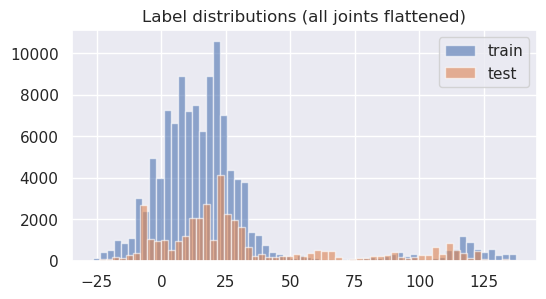

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.hist(labels_train_mean.flatten(), bins=60, alpha=0.6, label='train')
plt.hist(labels_test_mean.flatten(),  bins=60, alpha=0.6, label='test')
plt.legend(); plt.title('Label distributions (all joints flattened)')
plt.show()

In [45]:
import numpy as np

# emg_train_windows : (57309, 120, 16)
# labels_train_windows : (57309, 5)

L = emg_train_windows.shape[1]   # 120 samples per window

# MUST BE SAVED WHEN YOU CREATED WINDOWS
# list of start indices for each window
window_start_idxs = window_start_indices_train  

# take 10 random windows
idxs = np.random.randint(0, len(emg_train_windows), 10)

for i in idxs:
    start = window_start_idxs[i]
    center = start + L//2

    label_used = labels_train_windows[i]              # what your regression uses
    glove_center = glove_fingers[center]              # the TRUE label at center of window

    print("WIN", i)
    print(" start =", start, "center =", center)
    print(" label_used       =", label_used)
    print(" glove_at_center  =", glove_center)
    print(" -----------")

NameError: name 'window_start_indices_train' is not defined

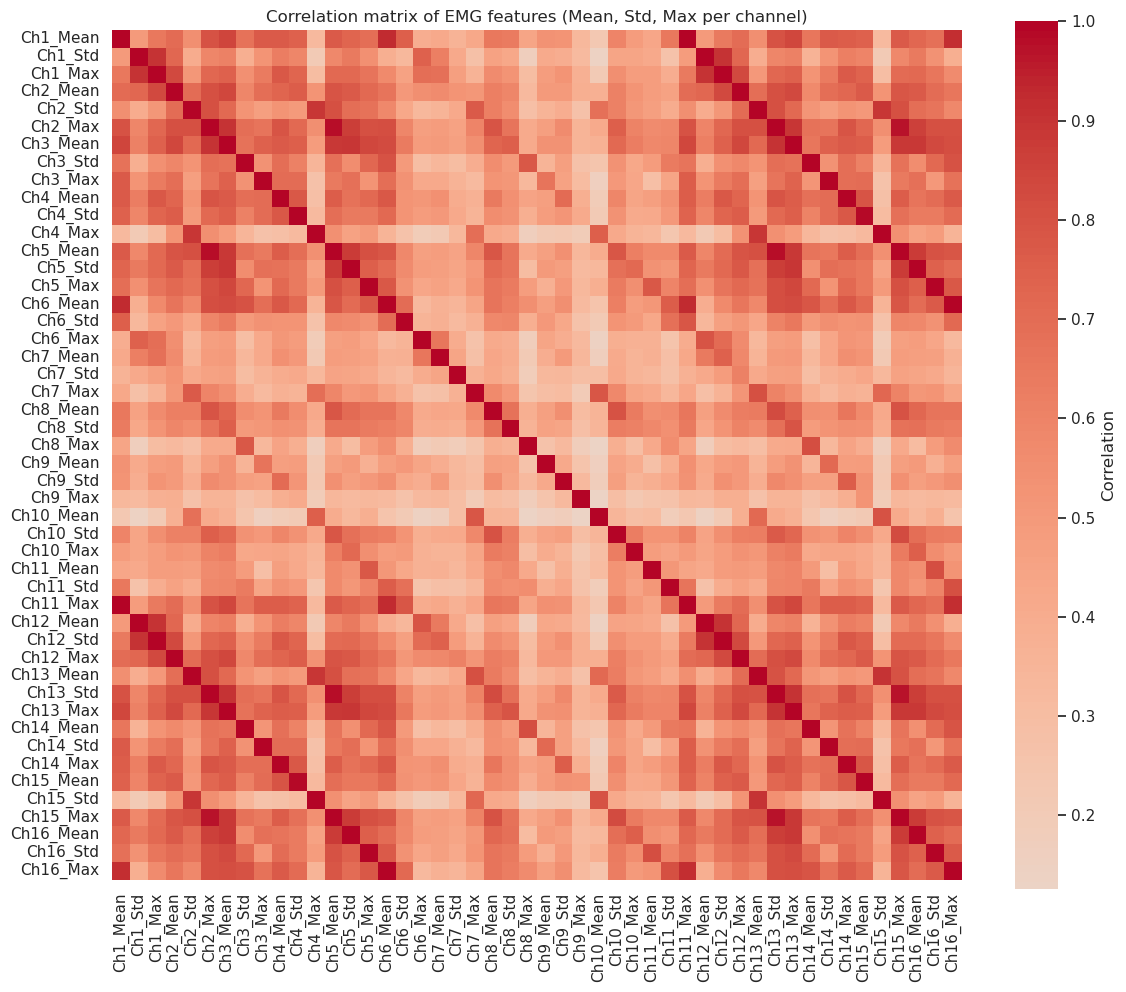

In [18]:

# 2. Compute correlation matrix
#corr_matrix = np.corrcoef(emg_train_norm, rowvar=False)  # shape (48,48)
corr_matrix = np.corrcoef(x_train_sc, rowvar=False)  # shape (48,48)

# 3. Build readable labels: "Ch1_Mean", "Ch1_Std", "Ch1_Max", ...
n_channels = 16
feature_types = ["Mean", "Std", "Max"]
labels = []
for ch in range(1, n_channels+1):
    for ftype in feature_types:
        labels.append(f"Ch{ch}_{ftype}")

# 4. Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, xticklabels=labels, yticklabels=labels, cmap="coolwarm", center=0,
            cbar_kws={'label': 'Correlation'}, square=True)
plt.title("Correlation matrix of EMG features (Mean, Std, Max per channel)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

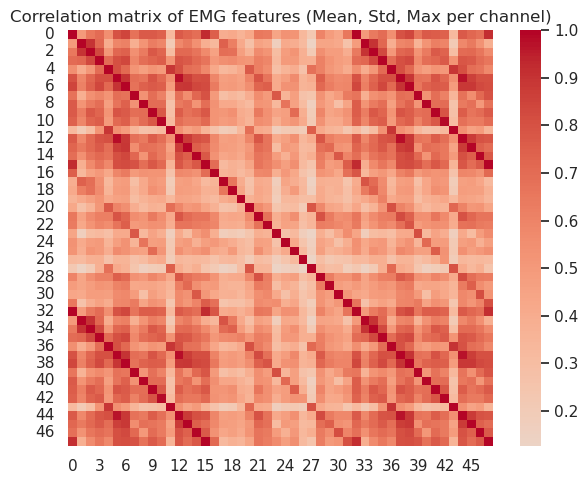

In [71]:
import seaborn as sns

corr_matrix = np.corrcoef(emg_train_norm.T)

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation matrix of EMG features (Mean, Std, Max per channel)")
plt.tight_layout()
plt.show()

# 4. Perform Regression on Kinematics - Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor


#initialazing the regressor
rf = RandomForestRegressor(n_estimators=20,max_depth=None,random_state=42,n_jobs=-1)

#Fit on training set
#rf.fit(emg_train_scaled, labels_train_scaled)
rf.fit(x_train_scaled, y_train_scaled)
#rf.fit(emg_train_extracted_features, labels_train_mean)

#y_pred = rf.predict(emg_test_norm)
y_pred_scaled= rf.predict(x_test_scaled)
#y_pred = rf.predict(emg_test_extracted_features)

In [33]:
from sklearn.metrics import mean_squared_error,r2_score

#first we need to calculate inverse transform --> return to angles
y_pred_real = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = labels_test_mean  # original raw angles

#Evaluate by Computing the mean squared error
mse_per_joint = mean_squared_error(y_test_real, y_pred_real)
r2_per_joint = r2_score(y_test_real, y_pred_real)

print("MSE per joint (real):")
for j in range(labels_test_mean.shape[1]):
    print(j, mean_squared_error(labels_test_mean[:,j], y_pred[:,j]), r2_score(labels_test_mean[:,j], y_pred[:,j]))

MSE per joint (real):
0 1415.4308161706222 -3.522378639384775
1 3156.5387178316687 -2.0957991169035997
2 3361.6338568968017 -0.9726518201575998
3 1976.0478226214948 -0.5024999976662674
4 2094.8745619664787 -0.18832106964231277


Visualization of the error

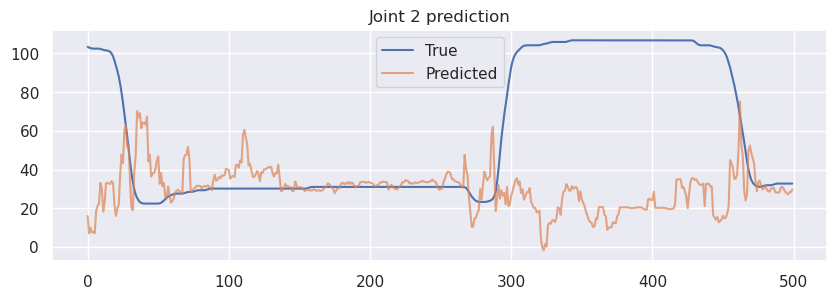

In [39]:
joint_idx = 1  # first joint
plt.figure(figsize=(10,3))
plt.plot(labels_test_mean[:500, joint_idx], label="True")
plt.plot(y_pred_real[:500, joint_idx], label="Predicted", alpha=0.7)
plt.legend()
plt.title(f"Joint {joint_idx+1} prediction")
plt.show()

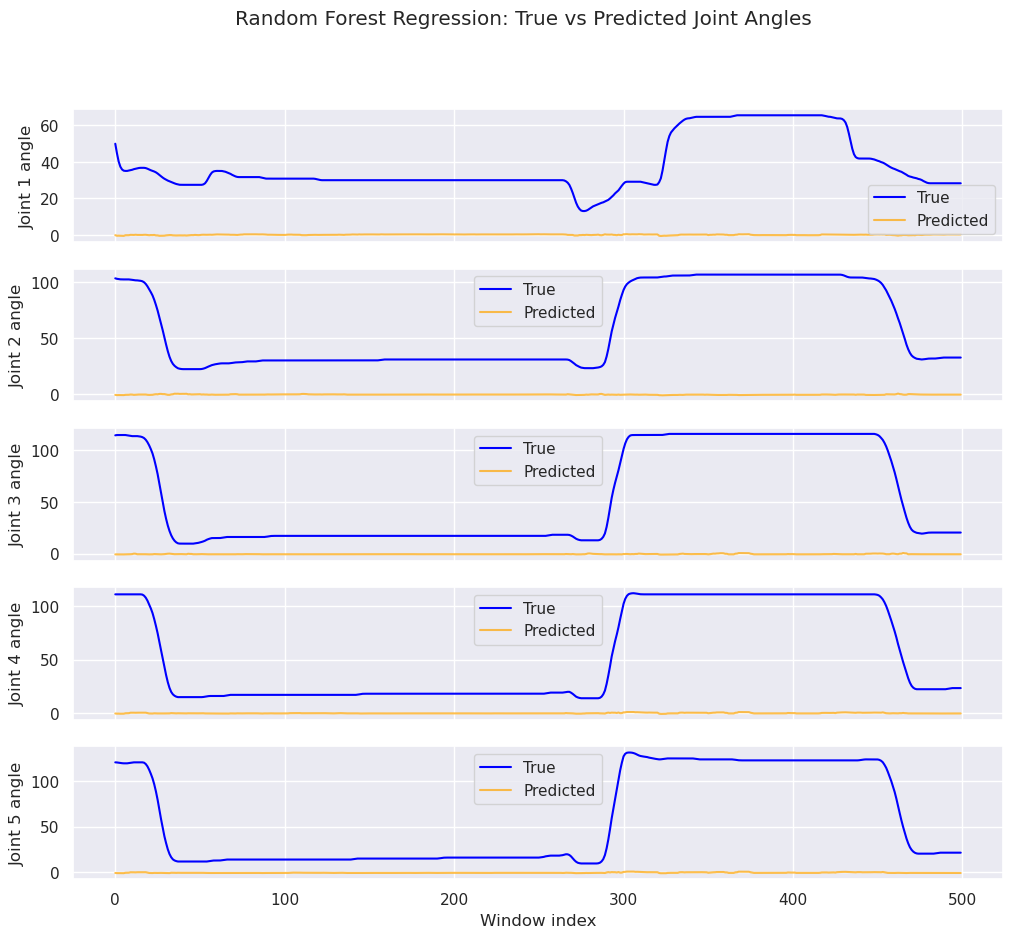

In [25]:
# --- VISUALIZATION ---

# Plot true vs predicted for each joint (first 500 windows as example)
n_plot = 500
fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
for i in range(5):
    axes[i].plot(labels_test_mean[:n_plot, i], label='True', color='blue')
    axes[i].plot(y_pred[:n_plot, i], label='Predicted', color='orange', alpha=0.7)
    axes[i].set_ylabel(f'Joint {i+1} angle')
    axes[i].legend()
axes[-1].set_xlabel('Window index')
plt.suptitle('Random Forest Regression: True vs Predicted Joint Angles')
plt.show()